# Crystal Quest Environment

- modeled off of https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py and
https://github.com/openai/gym/blob/master/gym/envs/atari/atari_env.py
- will put in external file when done

In [140]:
import sys
sys.path.append('../crystal_quest/')
import crystal_quest_env as cq
import imp 
imp.reload(cq) # reload after making changes

<module 'crystal_quest_env' from '../crystal_quest/crystal_quest_env.py'>

In [141]:
env = cq.Wave1Env()

In [142]:
obs = env.reset()
env.ship_location

array([20, 20])

# Crystal Quest Rendering Environment (Simplest)

In [42]:
# randomly sampling actions and visualizing 
env = cq.Wave1Env()
obs = env.reset()
for i in range(50):
    obs,r,done = env.step(env.action_space.sample())
    env.render()
env.render(close=True)

# Approximate Q-Learning

TO-DO: 
- fix env to 2 crystals, one alien. 
- make the reward output something based on given reward? 

**feature extractor** 
$f(s) $
- x,y distance to crystal 1
- x,y distance to crystal 2 
- x,y distance to alien 
- vx,vy velocity of alien. 
- vx,vy veloicty of ship

**Reward Function**
$r(s)$
- crystal obtained
- alien killed us. 
- asteroid killed us. 

**Q-learning with the given reward function** 
- does the agent have sensible behavior? 
- a =  {1,2,3,4,5}
- $ Q(s,a) = \theta^T f(s) $
- initialize Q-value 5*5 actions. 
- for i until?  
    - choose action max(q(f(s),a)
    - 


**recovering reward function** 
- generate a bunch of behavior with reward function built into game (or given in game)
- start a new alg.. that updates Q agent and R function.. 
- 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

In [15]:
def feature_extracter_simple_orig(env):
    # lazily just going to run off the env because I didn't get the obs encoding.. 
    
    # xy distance to first crystal. 
    if len(env.crystal_locations)>0: 
        xydict_c1 = np.subtract(np.array(env.ship_location),np.array(env.crystal_locations[0]))
    else:
        xydict_c1 = np.array([0,0])
        
    if len(env.crystal_locations)>1: 
        xydict_c2 = np.subtract(np.array(env.ship_location),np.array(env.crystal_locations[1]))
    else:
        xydict_c2 = np.array([0,0])

    feature_vect = np.concatenate((xydict_c1,xydict_c2))
    
    return(feature_vect)

In [89]:
def feature_extracter_simple(env):
    # lazily just going to run off the env because I didn't get the obs encoding.. 
    
    # xy distance to first crystal. 
    if len(env.crystal_locations)>0: 
        xydict_c1 = np.subtract(np.array(env.ship_location),np.array(env.crystal_locations[0]))
    else:
        xydict_c1 = np.array([0,0])
     
    #xydict_c1/1
    #xydict_c1 = xydict_c1/np.sum(np.abs(xydict_c1))
    return(xydict_c1/10.0)

In [106]:
class q_learner:
    def __init__(self, **args):
        # initialize thetas for q function
        self.thetas = np.random.normal(0,1,len(feature_vect)*5).reshape(len(feature_vect),5)
        #self.thetas = np.zeros((4,5))
        
                #
        good_thetas = np.zeros((2,5))
        good_thetas[:,0]=0

        # up actions 
        good_thetas[1,1]=-.5 # crystal 1 y, if above you go up. 

        # down actions, negative weight so the value is high 
        good_thetas[1,2]=.5 # crystal 1 y

        ####
        # left actions 
        good_thetas[0,3]=.5 # crystal 1 y, if above you go up. 

        # down actions, negative weight so the value is high 
        good_thetas[0,4]=-.5 # crystal 1 y

        self.thetas=good_thetas
        
        # initialize other stuff
        self.eps_greedy=0.05
        self.gamma=0.99
        self.alpha = 0.01
        self.inv_temp = 10.0
        
    def calculateQval(self,feature_vect,action):
        return(np.dot(self.thetas[:,action],feature_vect))
    
    def getAction(self,feature_vect):
        
        qvals = np.array([self.calculateQval(feature_vect,a) for a in range(5)])
        
        # softmax
        pvals = np.exp(qvals/self.inv_temp)/np.sum(np.exp(qvals/self.inv_temp))
        
        action = np.where(np.random.multinomial(1,pvals))[0][0]
    
        #greedy = np.random.binomial(1,1-self.eps_greedy)
        #if greedy:
        #    action = np.argmax(np.array(qvals))
        #else:
        #    action = np.random.randint(5)
        return(action)#is 1-5
        
    def update_q_value(self,action,feature_vect_t,feature_vect_tp1,reward):
        
        # next best action
        qval_tp1_best = np.max([self.calculateQval(feature_vect,a) for a in range(5)])
        
        # current q-value
        qval_tp = self.calculateQval(feature_vect_t,action)
        
        # calculate td
        td = (reward + self.gamma*qval_tp1_best) - qval_tp
        
        # update theta  
        self.thetas[:,action]+= self.alpha*td*feature_vect_t

        
    

# testing with good thetas

- this works to go to the first crystal 

In [143]:
#
good_thetas = np.zeros((2,5))
good_thetas[:,0]=0

# up actions 
good_thetas[1,1]=-.5 # crystal 1 y, if above you go up. 

# down actions, negative weight so the value is high 
good_thetas[1,2]=.5 # crystal 1 y

####
# left actions 
good_thetas[0,3]=.5 # crystal 1 y, if above you go up. 

# down actions, negative weight so the value is high 
good_thetas[0,4]=-.5 # crystal 1 y



In [144]:
good_thetas

array([[ 0. ,  0. ,  0. ,  0.5, -0.5],
       [ 0. , -0.5,  0.5,  0. ,  0. ]])

In [146]:
import time
render = True
# single episode 
obs = env.reset()
feature_vect = feature_extracter_simple(env)
agent = q_learner(feature_vect=feature_vect) #initial agent 
agent.inv_temp=0.1
for i in range(500):

    time.sleep(0.1) # seconds
    
    agent.thetas=good_thetas

    # choose action a
    action = agent.getAction(feature_vect)

    # take action, update env, get s'
    obs,r,done = env.step(action)
    if r==1:
        done=1
    feature_vect = feature_extracter_simple(env)
    if done:
        break
    if render:
        env.render()
if render:
    env.render(close=True)    

In [94]:
obs = env.reset()
env.ship_location

array([20, 20])

In [95]:
feature_vect

array([-0.2, -0.5])

# learning? 

In [111]:
render=True
env = cq.Wave1Env()
finished = []

obs = env.reset()
feature_vect = feature_extracter_simple(env)

# initialize the agent only once 
agent = q_learner(feature_vect=feature_vect) #initial agent 

agent.alpha=0.1
agent.inv_temp=1.0

for ep in range(1):
    obs = env.reset()
    feature_vect = feature_extracter_simple(env)

    # single episode 
    for i in range(1):
        # store previous observation f(s) for s 
        feature_vect_prev = feature_vect.copy()

        # choose action a
        action = agent.getAction(feature_vect)

        # take action, update env, get s'
        obs,r,done = env.step(action)
        if r==1:
            done=1
            pass
        
        if done:
            break

        # calculate feature vect again  f(s')
        feature_vect = feature_extracter_simple(env)

        # update q-value
        agent.update_q_value(action,feature_vect_prev,feature_vect,r)
        if render:
            env.render()
            #qvals = np.array([agent.calculateQval(feature_vect,a) for a in range(5)])
            #print(qvals)
    finished.append(i)
        
if render:
    env.render(close=True)    

In [112]:
agent.thetas

array([[ 0.11088,  0.     ,  0.     ,  0.5    , -0.5    ],
       [ 0.12672, -0.5    ,  0.5    ,  0.     ,  0.     ]])

In [114]:
action

0

In [99]:
agent.thetas


array([[  7.49039965,  11.53790457,   9.42981382,   0.65121648,
          2.36745581],
       [  7.46088674,   0.72327013,   3.84453195,  -1.59939577,
         15.46022958]])

In [100]:
np.dot(feature_vect,agent.thetas[:,1])

38.29550787713395

In [101]:
agent.thetas

array([[  7.49039965,  11.53790457,   9.42981382,   0.65121648,
          2.36745581],
       [  7.46088674,   0.72327013,   3.84453195,  -1.59939577,
         15.46022958]])

In [102]:
feature_vect

array([ 3.2,  1.9])

In [103]:
agent.getAction(feature_vect)

4

In [104]:
feature_vect


array([ 3.2,  1.9])

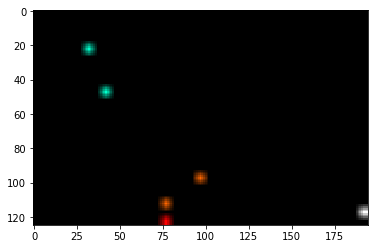

In [105]:
env._internal_to_observation()
plt.imshow(env._return_img())

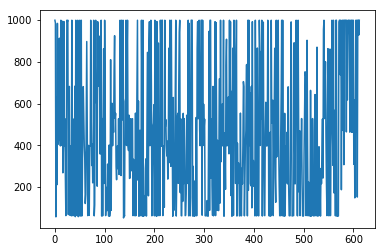

In [63]:
plt.plot(finished)

In [64]:
render=True
obs = env.reset()
feature_vect = feature_extracter_simple(env)
for i in range(100):
    # store previous observation f(s) for s 
    feature_vect_prev = feature_vect.copy()

    # choose action a
    action = agent.getAction(feature_vect)

    # take action, update env, get s'
    obs,r,done = env.step(action)
    if r==1:
        pass

    if done:
        break

    time.sleep(0.01) # seconds
    # calculate feature vect again  f(s')
    feature_vect = feature_extracter_simple(env)

    # update q-value
    agent.update_q_value(action,feature_vect_prev,feature_vect,r)
    if render:
        env.render()
if render:
    env.render(close=True) 

In [65]:
agent.thetas

array([[ 15.9992041 ,  16.07172165,  15.95324524,   1.85502666,
         12.18333014],
       [ 21.11539011,  21.18088079,  20.65207697,  -0.78112944,
         28.10154417]])

In [66]:
qval_tp1_best = np.max([agent.calculateQval(feature_vect,a) for a in range(5)])
[agent.calculateQval(feature_vect,a) for a in range(5)]

[17.704599435101848,
 17.774774697559227,
 17.519522482412349,
 0.97630795760063571,
 17.489401480689274]

In [67]:
qvals = np.array([agent.calculateQval(feature_vect,a) for a in range(5)])

agent.inv_temp=1.0
# softmax
pvals = np.exp(qvals/agent.inv_temp)/np.sum(np.exp(qvals/agent.inv_temp))
print(pvals)

[  2.69533181e-01   2.89127210e-01   2.23992944e-01   1.46422412e-08
   2.17346651e-01]


In [68]:
qvals

array([ 17.70459944,  17.7747747 ,  17.51952248,   0.97630796,  17.48940148])

# Scratch

In [69]:
feature_vect

array([ 0.66666667,  0.33333333])

In [70]:
feature_vect_prev

array([ 0.68085106,  0.31914894])

In [71]:
[agent.calculateQval(feature_vect,a) for a in range(5)]

[17.704599435101848,
 17.774774697559227,
 17.519522482412349,
 0.97630795760063571,
 17.489401480689274]

In [85]:
feature_vect

array([ 0.66666667,  0.33333333])

In [86]:
qval_tp1_best = np.max([agent.calculateQval(feature_vect,a) for a in range(5)])
qval_tp1_best

17.774774697559227

In [88]:
feature_vect_prev

array([ 0.68085106,  0.31914894])

In [84]:
qval_tp = agent.calculateQval(feature_vect_prev,action)
qval_tp

17.702304355251506

In [76]:

# calculate td
td = (0 + agent.gamma*qval_tp1_best) - qval_tp
td

-0.10527740466786994

In [77]:
td

-0.10527740466786994

In [78]:
feature_vect_prev

array([ 0.68085106,  0.31914894])

In [79]:
agent.alpha

0.1

In [80]:
agent.alpha*td*feature_vect_prev

array([-0.00716782, -0.00335992])

In [1390]:

# update theta  
self.thetas[:,action]+= self.alpha*td*feature_vect_t
self.thetas[:,action]=self.thetas[:,action]/np.sum(np.abs(self.thetas[:,action]))


NameError: name 'self' is not defined

In [136]:
import argparse
import gym
from gym import wrappers
import os.path as osp
import random
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers

In [137]:
def get_env(task, seed):
    env_id = task.env_id

    env = gym.make(env_id)

    set_global_seeds(seed)
    env.seed(seed)

    expt_dir = '/tmp/hw3_vid_dir2/'
    env = wrappers.Monitor(env, osp.join(expt_dir, "gym"), force=True)
    env = wrap_deepmind(env)

    return env

In [138]:
def set_global_seeds(i):
    try:
        import tensorflow as tf
    except ImportError:
        pass
    else:
        tf.set_random_seed(i)
    np.random.seed(i)
    random.seed(i)